In [23]:
import matplotlib.pyplot as plt
import numpy as np
import string
import torch
import torch.nn as nn
import nltk
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.decomposition import PCA

np.random.seed(32)

In [ ]:
contents = []

path = "dataset.txt"

with open(path, "r", encoding="utf-8") as file:
    i = 0
    for line in file:
        if i >= 10000000:
            break
        contents.append(line.lower().split())
        i += 1

print(len(contents))

In [ ]:
words = []
for line in contents:
    for word in line:
        words.append(word)

print("total words -", len(words))
print("unique words -", len(set(words)))

total words - 114339451
unique words - 563959


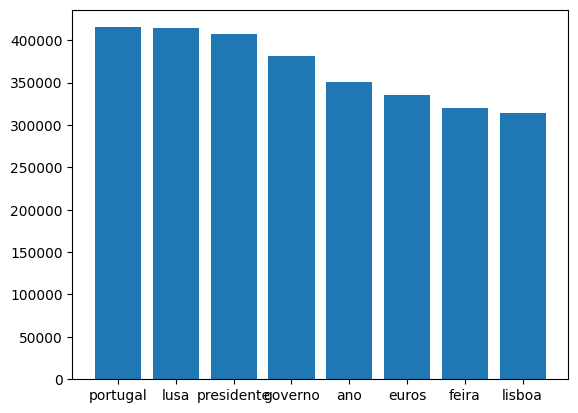

In [ ]:
freq_dist = nltk.FreqDist(words)
plt.figure()
plt.bar(
    x=[x[0] for x in freq_dist.most_common(8)],
    height=[x[1] for x in freq_dist.most_common(8)],
)
plt.show()

In [ ]:
VOCAB_SIZE = 20000
C = 4

vocab = set([w[0] for w in freq_dist.most_common(VOCAB_SIZE)])
word_to_ix = {word: i for i, word in enumerate(sorted(vocab))}
ix_to_word = {i: word for i, word in enumerate(sorted(vocab))}

CBOW

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_SIZE = 300


class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CBOW, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size, max_norm=10)

        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        # inputs : (batch_size x C)
        embedding = self.embedding(inputs).mean(axis=1)
        out = self.linear(embedding)

        return out

In [ ]:
model = CBOW(VOCAB_SIZE, EMBEDDING_SIZE).to(device)
model.load_state_dict(torch.load("model_weights10"))
model.eval()

emb_matrix = list(model.parameters())[0]

emb_matrix

Parameter containing:
tensor([[ 1.8600, -0.5842,  0.0111,  ...,  0.5706, -0.2642, -0.3880],
        [-0.3148,  0.2817,  0.1301,  ...,  0.1535, -0.4328, -0.0459],
        [-0.7661,  0.1849,  0.0743,  ...,  0.8035,  0.0177, -0.3972],
        ...,
        [-0.2522,  0.4313, -0.1857,  ...,  0.4312, -0.1504, -1.3942],
        [ 0.3997, -0.6839, -0.5783,  ..., -0.3125, -0.5671,  0.3966],
        [-0.7434, -0.9814,  0.1273,  ..., -0.7991, -0.2330, -0.3072]],
       device='cuda:0', requires_grad=True)

In [ ]:
def find_closest_words(emb_matrix, words, k=5):

    word_embedding = sum([emb_matrix[word_to_ix[w]] for w in words]) / len(words)

    similarities = nn.functional.cosine_similarity(emb_matrix, word_embedding)

    values, indices = torch.topk(similarities, k + 1)

    return [i.item() for i in indices], [v.item() for v in values]


def print_closest_words(emb_matrix, words, k=5):

    indices, values = find_closest_words(emb_matrix, words, k)

    for i in range(k + 1):
        print(ix_to_word[indices[i]], "-", round(values[i], 3))


def plot_embeding(emb_matrix, words, k, method):

    emb_matrix_cpu = emb_matrix.cpu().detach().numpy()

    sim_words = []
    sim_ixs = []
    for w in words:
        sim_ix, _ = find_closest_words(emb_matrix, [w], k)
        sim_words += [ix_to_word[w] for w in sim_ix]
        sim_ixs += sim_ix

    if method == "PCA":
        proj = PCA(random_state=0).fit_transform(emb_matrix_cpu[sim_ixs])[:, :2]
    else:
        proj = TSNE(n_components=2, random_state=0).fit_transform(
            emb_matrix_cpu[sim_ixs]
        )[:, :2]

    data = []

    data.append(
        go.Scatter(
            x=proj[0 : len(sim_words) : k + 1, 0],
            y=proj[0 : len(sim_words) : k + 1, 1],
            text=sim_words[0 : len(sim_words) : k + 1],
            name="input words",
            textposition="top center",
            textfont_size=15,
            mode="markers+text",
            marker={"size": 20, "opacity": 1, "color": "black"},
        )
    )

    for i in range(0, len(sim_words) - k + 1, k + 1):

        data.append(
            go.Scatter(
                x=proj[i + 1 : i + k + 1, 0],
                y=proj[i + 1 : i + k + 1, 1],
                text=sim_words[i + 1 : i + k + 1],
                name=sim_words[i],
                textposition="top center",
                textfont_size=15,
                mode="markers+text",
                marker={"size": 10, "opacity": 0.8, "color": 2},
            )
        )

    layout = go.Layout(
        margin={"l": 0, "r": 0, "b": 0, "t": 0},
        showlegend=True,
        legend=dict(
            x=1, y=0.5, font=dict(family="Courier New", size=15, color="black")
        ),
        font=dict(family=" Courier New ", size=1),
        autosize=False,
        width=800,
        height=600,
    )

    plot_figure = go.Figure(data, layout)
    plot_figure.show()


def plot_embeding3D(emb_matrix, words, k):

    emb_matrix_cpu = emb_matrix.cpu().detach().numpy()

    sim_words = []
    sim_ixs = []
    for w in words:
        sim_ix, _ = find_closest_words(emb_matrix, [w], k)
        sim_words += [ix_to_word[w] for w in sim_ix]
        sim_ixs += sim_ix

    proj = PCA(random_state=0).fit_transform(emb_matrix_cpu[sim_ixs])[:, :3]

    data = []

    data.append(
        go.Scatter3d(
            x=proj[0 : len(sim_words) : k + 1, 0],
            y=proj[0 : len(sim_words) : k + 1, 1],
            z=proj[0 : len(sim_words) : k + 1, 2],
            text=sim_words[0 : len(sim_words) : k + 1],
            name="input words",
            textposition="top center",
            textfont_size=15,
            mode="markers+text",
            marker={"size": 15, "opacity": 1, "color": "black"},
        )
    )

    for i in range(0, len(sim_words) - k + 1, k + 1):

        data.append(
            go.Scatter3d(
                x=proj[i + 1 : i + k + 1, 0],
                y=proj[i + 1 : i + k + 1, 1],
                z=proj[i + 1 : i + k + 1, 2],
                text=sim_words[i + 1 : i + k + 1],
                name=sim_words[i],
                textposition="top center",
                textfont_size=15,
                mode="markers+text",
                marker={"size": 5, "opacity": 0.8, "color": 2},
            )
        )

    # Define the layout
    layout = go.Layout(
        margin={"l": 0, "r": 0, "b": 0, "t": 0},
        showlegend=True,
        legend=dict(
            x=1, y=0.5, font=dict(family="Courier New", size=15, color="black")
        ),
        font=dict(family=" Courier New ", size=1),
        autosize=False,
        width=800,
        height=600,
    )

    plot_figure = go.Figure(data, layout)
    plot_figure.show()

In [ ]:
plot_embeding3D(emb_matrix, ["ps", "futebol", "mãe", "carne", "ensino"], 10)

In [ ]:
plot_embeding(emb_matrix, ["ps", "futebol", "mãe", "carne", "ensino"], 10, "TSNE")

In [ ]:
plot_embeding(emb_matrix, ["1", "março", "joão", "gramas"], 10, "TSNE")

In [ ]:
print_closest_words(emb_matrix, ["crime"], 5)

crime - 1.0
crimes - 0.625
homicídio - 0.401
roubo - 0.363
mp - 0.361
arguido - 0.355


In [ ]:
print_closest_words(emb_matrix, ["ronaldo"], 5)

ronaldo - 1.0
jogador - 0.413
avançado - 0.38
futebolista - 0.348
seleção - 0.309
compatriota - 0.308


In [ ]:
print_closest_words(emb_matrix, ["futebol", "encarnados"], 5)

encarnados - 0.79
futebol - 0.79
benfica - 0.647
leões - 0.641
sporting - 0.595
dragões - 0.547


In [ ]:
print_closest_words(emb_matrix, ["futebol", "leões"], 5)

futebol - 0.814
leões - 0.812
sporting - 0.643
benfica - 0.625
encarnados - 0.578
dragões - 0.557


In [ ]:
print_closest_words(emb_matrix, ["ensino", "jovens"], 5)

jovens - 0.769
ensino - 0.766
alunos - 0.544
estudantes - 0.535
crianças - 0.372
professores - 0.369


In [ ]:
def emb_operation(emb_matrix, positive, negative, k=5):

    pos_embedings = [emb_matrix[word_to_ix[w]] for w in positive]
    neg_embedings = [emb_matrix[word_to_ix[w]] for w in negative]

    res = sum(pos_embedings) - sum(neg_embedings)

    similarities = nn.functional.cosine_similarity(emb_matrix, res)

    values, indices = torch.topk(similarities, k + 1)

    for i in range(k + 1):
        print(ix_to_word[indices[i].item()], "-", round(values[i].item(), 3))

In [ ]:
emb_operation(emb_matrix, ["mãe", "homem"], ["mulher"], 5)

homem - 0.711
mãe - 0.69
pai - 0.396
bebé - 0.395
jovem - 0.394
filho - 0.384


In [ ]:
emb_matrix_cpu = emb_matrix.cpu().detach().numpy()

proj = PCA(random_state=0).fit_transform(emb_matrix_cpu)[:, :2]

# proj = TSNE(n_components = 2, random_state=0).fit_transform(emb_matrix_cpu[sim_ixs])[:,:2]

data = []

data.append(
    go.Scatter(
        x=proj[:, 0],
        y=proj[:, 1],
        text=sorted(vocab),
        name="words",
        textposition="top center",
        textfont_size=10,
        mode="markers+text",
        marker={"size": 5, "opacity": 1, "color": "black"},
    )
)

# Define the layout
layout = go.Layout(
    margin={"l": 0, "r": 0, "b": 0, "t": 0},
    showlegend=False,
    font=dict(family=" Courier New ", size=1),
    autosize=False,
    width=800,
    height=600,
)

plot_figure = go.Figure(data, layout)
plot_figure.show()